# Piecewise-Linear Regression

### `SMC` approach

In [1]:
# import libraries
import import_ipynb
import toolbox_sccf as sccf
import toolbox_SMC_backend as smc

## basic imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
import seaborn as sns
import cvxpy as cp
import time
clear_output()
myseed = '120824' 
np.random.seed(int(myseed))

In [2]:
## problem dimensions

w = int(2)
B1 = int(5) 
B2 = int(5) 
N = int(1.5e3)
L = 100.0 # X search space dim

radius_data = 10 

## data representation
mode = 'full' # others include 'regular','truncated'
stand = False # others include False 

### synthetic data generation

In [3]:
from scipy.stats import ortho_group

def gt(omegas):
    return np.array([1/10*omega[-1]**3 + 1*np.sin(sum(omega)) + 4+omega[0]*omega[1]-2/10*np.sum(omega)**2 for omega in omegas]) 

In [4]:
'''
generate "num_points" random points in "dimension" that have uniform
 probability over the unit ball scaled by "radius" (length of points
 are in range [0, "radius"]).
'''

# https://stackoverflow.com/questions/54544971/how-to-generate-uniform-random-points-inside-d-dimension-ball-sphere 

def random_ball(num_points, dimension, radius=1):
    random_directions = np.random.normal(size=(dimension,num_points))
    random_directions /= np.linalg.norm(random_directions, axis=0)
    random_radii = np.random.random(num_points) ** (1/dimension)
    return radius * (random_directions * random_radii).T


omegas = random_ball(N,w,radius=radius_data)
taus = gt(omegas)

In [5]:
omega1 = np.linspace(-radius_data, radius_data, int(2e2))
omega2 = np.linspace(-radius_data, radius_data, int(2e2))

OMEGA1, OMEGA2 = np.meshgrid(omega1, omega2)   
list_omegas = []
for o1 in omega1:
    for o2 in omega2:
        list_omegas.append([o1,o2])

list_omegas = np.array(list_omegas)

### utils

In [6]:
'''
utils (global)
'''    

def extended_omegas(omegas,augmented=False):
    if augmented:
        N,d = omegas.shape
        embedding = np.zeros((N,int(d+d*(d+1)/2)))
        for s,samp in enumerate(omegas):
            new_omega = list(samp)
            buf = np.outer(samp,samp)
            for ofd in range(d):
                new_omega += list(np.diagonal(buf,ofd))
            embedding[s] = np.array(new_omega)
    else:
        embedding = omegas.copy()
    return np.hstack((embedding,np.ones((len(omegas),1))))

def rescale(data):
    num_samples,num_features = data.shape
    new_data = data.copy()
    means,stds = [],[]
    for colid,feat in enumerate(data.T):
        mfeat,stdfeat = np.mean(feat),np.std(feat)
        means.append(mfeat)
        stds.append(stdfeat)
        if stdfeat>0:
            new_data[:,colid] = (feat-mfeat)/stdfeat
    return new_data,means,stds

def coordinates(sigma_,B1_=B1,B2_=B2):
    assert sigma_>=0 and sigma_<=B1_*B2_-1, 'value range error (0 -> H-1)'
    e2 = sigma_%B2_
    e1 = (sigma_-(e2-1))/B2_
    return (int(e1),int(e2))

def selector(coordinates,B1_=B1,B2_=B2):
    return coordinates[1]+coordinates[0]*B2_

def recast(x,w_ext,B1_=B1,B2_=B2):
    assert len(x)==(B1_+B2_)*w_ext, 'dimension error'
    mat = x.reshape((B1_+B2_,w_ext))
    return mat[:B1_],mat[B1_:]

def mix(mat1,mat2):
    assert mat1.shape[1]==mat2.shape[1],'dimension error'
    buf = []
    for lm1 in mat1:
        for lm2 in mat2:
            buf.append(list(lm1+lm2))
    return np.array(buf)

def unfold(mat1,mat2):
    return (np.vstack((mat1,mat2))).flatten()

In [7]:
if mode=='regular':
    ext_omegas = extended_omegas(omegas)
    ext_list_omegas = extended_omegas(list_omegas)
else:
    ext_omegas_full = extended_omegas(omegas,True)
    ext_list_omegas_full = extended_omegas(list_omegas,True)
    if mode=='full':
        ext_omegas = ext_omegas_full.copy()
        ext_list_omegas = ext_list_omegas_full.copy()
    else:
        max_dim = ext_omegas_full.shape[1]-1
        select = np.concatenate((np.random.choice(np.arange(max_dim),replace=False,size=int(max_dim*2/3)),[max_dim]))
        ext_omegas = ext_omegas_full[:,select]
        ext_list_omegas = ext_list_omegas_full[:,select]

if stand:
    polished_omegas,means,stds = rescale(ext_omegas)
else:
    polished_omegas,means,stds = ext_omegas.copy(),np.zeros(len(ext_omegas)),np.zeros(len(ext_omegas))
    
polished_list_omegas = []
for idcol,col in enumerate(ext_list_omegas.T):
    if stds[idcol]>0:
        polished_list_omegas.append((col-means[idcol])/stds[idcol])
    else:
        polished_list_omegas.append(col)
polished_list_omegas = np.array(polished_list_omegas).T

        
w_ext = len(polished_omegas[0])

In [8]:
N_train = min(len(omegas),int(1.5e3))
id_train = np.random.choice(np.arange(len(omegas)),replace=False,size=N_train)

omegas_train = omegas[id_train]
polished_omegas_train = polished_omegas[id_train]
taus_train = taus[id_train]

### package instance

In [9]:
# param
margin = .0

# variables
mat1_cvx = cp.Variable((B1,w_ext))
mat2_cvx = cp.Variable((B2,w_ext))

# constraints
list_cstr_cvx = [cp.norm(mat1_cvx[e1][:-1],'inf')<=L for e1 in range(B1)] + [cp.norm(mat2_cvx[e2][:-1],'inf')<=L for e2 in range(B2)]

# prior-knowledge encoding (-> symmetry breaking)
if B1>1:
    for e1 in range(B1-1):
        list_cstr_cvx += [cp.sum(mat1_cvx[e1])+margin<=cp.sum(mat1_cvx[e1+1])]
if B2>1:
    for e2 in range(B2-1):
        list_cstr_cvx += [cp.sum(mat2_cvx[e2])+margin<=cp.sum(mat2_cvx[e2+1])]

# objective function implementation
data = polished_omegas_train.copy()
target = taus_train.copy()
N_t = len(data)

val1_cvx,val2_cvx = mat1_cvx@data.T,mat2_cvx@data.T
mval1_cvx,mval2_cvx = cp.max(val1_cvx,0),cp.max(val2_cvx,0)
h_bar_cvx = cp.maximum(target+mval2_cvx,mval1_cvx)+cp.maximum(-target+mval1_cvx,mval2_cvx)
main_term = 1/N_t * cp.sum(h_bar_cvx)
list_expr = []
for l in range(B1*B2):
    e1_sel,e2_sel = coordinates(l)
    list_expr.append(-1/N_t * data@(mat1_cvx[e1_sel]+mat2_cvx[e2_sel]))

objective_smc = smc.SumMinExpr(list_min_exprs=[smc.MinExpr(list_expr)],main_fun=main_term)

prob_smc = smc.Problem(objective_smc,list_cstr_cvx)

In [10]:
'''NEW -> parametric speed-up'''

param_mat1_cvx = cp.Parameter((B1,w_ext))
param_mat2_cvx = cp.Parameter((B2,w_ext))

def w2p(weights):
    weight = weights[0].copy() # there should be a single element in weights; weight of size Nt,l=B1*B2
    param1 = np.zeros((B1,w_ext))
    param2 = np.zeros((B2,w_ext))
    for l in range(B1*B2):
        e1_sel,e2_sel = coordinates(l)
        vec_shift = weight[:,l]@data
        param1[e1_sel]+=vec_shift
        param2[e2_sel]+=vec_shift
    return [param1,param2]

objective_param_speed_smc = main_term-(1/N_t)*(cp.sum(cp.multiply(param_mat1_cvx,mat1_cvx))\
                                               +cp.sum(cp.multiply(param_mat2_cvx,mat2_cvx)))

In [11]:
'''NEW -> parametric sped-up smc.Problem'''
prob_smc_speed = smc.Problem(objective_smc,list_cstr_cvx,custom_param_expand=[objective_param_speed_smc,[param_mat1_cvx,param_mat2_cvx],w2p])

In [12]:
def part2weights(partition,B1_=B1,B2_=B2):
    N_loc = len(partition)
    buf = np.zeros((N_loc,B1_*B2_))
    for idtup,tup in enumerate(partition):
        buf[idtup,selector(tup)] += 1
    return [buf]

In [13]:
NREPS = int(50)

niters=[]
alg=[]
wc_times=[]
fval=[]
repID=[]

order=np.arange(N_train)

from sklearn.cluster import KMeans


for rep in range(NREPS):
    
    np.random.shuffle(order)

    
    kmeans1 = KMeans(n_clusters=int(B1),n_init=5).fit(omegas_train[order])
    kmeans2 = KMeans(n_clusters=int(B2),n_init=5).fit(omegas_train[order])
    
    """
    recovering of init affectation
    """
    _partition = []
    for e1,e2 in zip(kmeans1.labels_,kmeans2.labels_):
        _partition.append((e1,e2))
    
    rinit = part2weights(_partition)
    print('new rep #'+str(rep+1))
    print('---------------')
    print(' ')
    print(' ')
    
    tic = time.time()
    res_vandessel=prob_smc_speed.solve(method='vandessel',min_decr=1e-5,maxIters=int(200),verb_=False,extra_verb_=False,tol=1e-9,warm_start_weights=rinit.copy())
    toc = time.time()
    t_vandessel=toc-tic
    val_vandessel = res_vandessel['objective_values'][-1]
    print(' ')
    print('val='+str(val_vandessel))
    print('solved in '+str(np.round(t_vandessel,4))+' [s]')
    print(' ')
    tic = time.time()
    res_am=prob_smc_speed.solve(method='am',maxIters=int(200),verb_=False,extra_verb_=False,tol=1e-9,warm_start_weights=rinit.copy())
    toc = time.time()
    t_am=toc-tic
    val_am = res_am['objective_values'][-1]
    print(' ')
    print('val='+str(val_am))
    print('solved in '+str(np.round(t_am,4))+' [s]')
    print(' ')
    print(' ')
    
    # save
    niters += [res_vandessel['iters'],res_am['iters']]
    alg += ['vandessel','am']
    wc_times += [t_vandessel,t_am]
    fval += [val_vandessel,val_am]
    repID += [rep,rep]

new rep #1
---------------
 
 
 
val=0.613550355048659
solved in 55.9496 [s]
 
 
val=0.6007278204812323
solved in 17.2222 [s]
 
 
new rep #2
---------------
 
 
 
val=0.6465756939888934
solved in 59.796 [s]
 
 
val=0.668850047814999
solved in 17.2803 [s]
 
 
new rep #3
---------------
 
 
 
val=0.5874783621769808
solved in 50.1405 [s]
 
 
val=0.7192382082398581
solved in 10.3134 [s]
 
 
new rep #4
---------------
 
 
 
val=0.7047738669294006
solved in 23.963 [s]
 
 
val=0.7088225239486832
solved in 10.109 [s]
 
 
new rep #5
---------------
 
 
 
val=0.6461500932533264
solved in 66.0057 [s]
 
 
val=0.6522671759829883
solved in 27.0921 [s]
 
 
new rep #6
---------------
 
 
 
val=0.6564702866000793
solved in 83.6094 [s]
 
 
val=0.7152127627688358
solved in 32.4601 [s]
 
 
new rep #7
---------------
 
 
 
val=0.6563113190618424
solved in 65.1902 [s]
 
 
val=0.7529510139468201
solved in 16.6531 [s]
 
 
new rep #8
---------------
 
 
 
val=0.606535183829628
solved in 89.5296 [s]
 
 
val=0.7

In [16]:
import pandas as pd
df_plr_bench_ws = pd.DataFrame(data={'num_iters':niters,'algorithms':alg,\
                                     'wall-clock time':wc_times,'fval':fval,'repID':repID})
df_plr_bench_ws.to_csv('plr_bench_ws.csv')

In [19]:
df_plr_bench_ws

,num_iters,algorithms,wall-clock time,fval,repID
0,51,vandessel,55.949574,0.613550,0
1,27,am,17.222216,0.600728,0
2,58,vandessel,59.795993,0.646576,1
3,34,am,17.280312,0.668850,1
4,56,vandessel,50.140489,0.587478,2
...,...,...,...,...,...
95,40,am,28.936710,0.657558,47
96,34,vandessel,42.227948,0.673355,48
97,27,am,17.566964,0.702469,48
98,57,vandessel,63.636209,0.603370,49


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

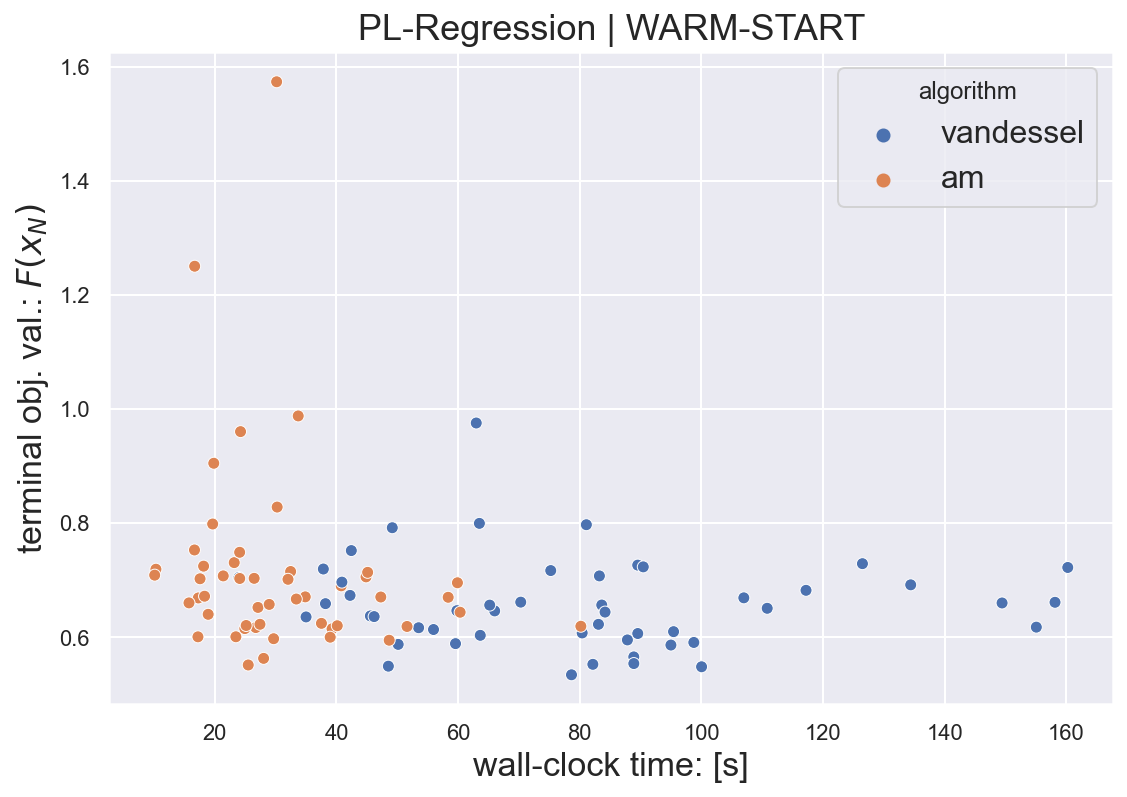

In [37]:
plt.figure(figsize=(9,6))
plt.title('PL-Regression | WARM-START',fontsize=18)
gfg=sns.scatterplot(data=df_plr_bench_ws,x='wall-clock time',y='fval',hue='algorithms')
gfg.legend(title='algorithm',fontsize=16)
plt.xlabel('wall-clock time: [s]',fontsize=17)
plt.ylabel('terminal obj. val.: $F(x_N)$',fontsize=17);

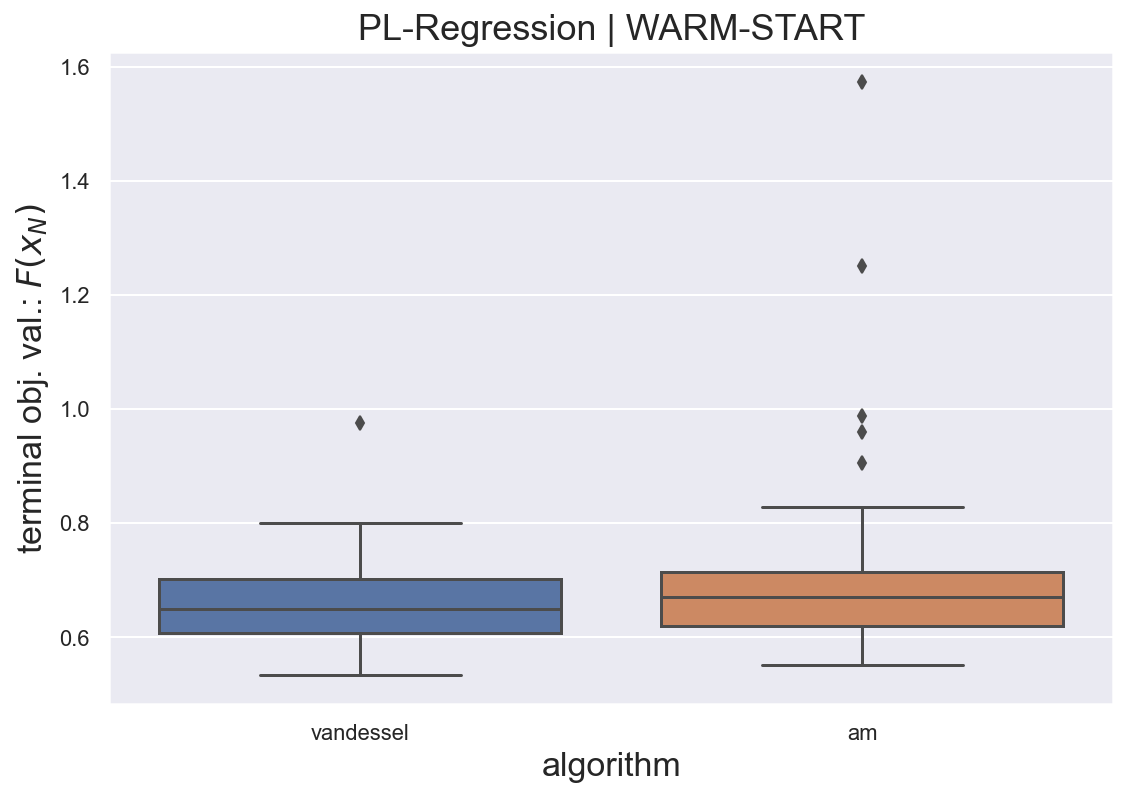

In [38]:
plt.figure(figsize=(9,6))
plt.title('PL-Regression | WARM-START',fontsize=18)
gfg=sns.boxplot(data=df_plr_bench_ws,x='algorithms',y='fval')
plt.xlabel('algorithm',fontsize=17)
plt.ylabel('terminal obj. val.: $F(x_N)$',fontsize=17);

In [39]:
for alg in df_plr_bench_ws['algorithms'].unique():
    print('algorithm: '+str(alg))
    print(df_plr_bench_ws[df_plr_bench_ws['algorithms']==alg].describe())
    print(' ')

algorithm: vandessel
        num_iters  wall-clock time       fval     repID
count   50.000000        50.000000  50.000000  50.00000
mean    60.300000        79.899424   0.657607  24.50000
std     23.705894        33.393187   0.079872  14.57738
min     22.000000        23.963030   0.534196   0.00000
25%     40.250000        54.115933   0.606784  12.25000
50%     57.000000        80.734115   0.648659  24.50000
75%     75.750000        93.844809   0.702736  36.75000
max    113.000000       160.224281   0.975477  49.00000
 
algorithm: am
        num_iters  wall-clock time       fval     repID
count   50.000000        50.000000  50.000000  50.00000
mean    40.480000        30.929927   0.713619  24.50000
std     18.048958        14.262394   0.172138  14.57738
min     18.000000        10.109007   0.551368   0.00000
25%     28.000000        20.212104   0.620252  12.25000
50%     35.000000        27.254700   0.670640  24.50000
75%     47.250000        38.603250   0.714848  36.75000
max    101.